In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Final_Data_cleaned.csv")

In [3]:
data['Text'] = data['Text'].astype(str)
data.head()

,Text,Label
0,"If your husband is going to work every day, pa...",1
1,gangbanged by wookies.,0
2,"The art of leadership is saying no, not yes. I...",0
3,"With or without payment, the work will be done.",0
4,"#womensrights, Just like to say I’m all for y’...",1


In [4]:
import tensorflow as tf
import sklearn
import seaborn as sbs
import sklearn.naive_bayes 
import sklearn.model_selection
import sklearn.metrics

In [5]:
!pip3 install bert-for-tf2

     |████████████████████████████████| 51kB 7.2MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.9-cp37-none-any.whl size=30535 sha256=53e691500edc1d37aaac27b3dcc18e9e3a3e56d81bc85eea1ca5b2cf24070532
  Stored in directory: /root/.cache/pip/wheels/a1/04/ee/347bd9f5b821b637c76411d280271a857aece00358896a230f
  Created wheel for py-params: filename=py_params-0.10.2-cp37-none-any.whl size=7912 sha256=dd4247e7938b1e903ad987286419bc67d2b1f8fca7097d9f78ae7311894adae8
  Stored in directory: /root/.cache/pip/wheels/d0/4a/70/ff12450229ff1955abf01f365051d4faae1c20aef53ab4cf09
  Created wheel for params-flow: filename=params_flow-0.8.2-cp37-none-any.whl size=19472 sha256=555f6668b0571bdb5035221f3d4640f9136210f4f2e17d46c21ff52a84230aed
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be03e679e596067dc630c06
Successfully built bert-for-tf2 py-params params-flow


In [6]:
import tensorflow_hub as hub 
from bert import bert_tokenization
module_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [7]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

In [8]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence) + [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

def build_model(bert_layer, max_len=512):
    input_word_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    net = tf.keras.layers.Dense(64, activation='relu')(clf_output)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(32, activation='relu')(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(net)
    
    model = tf.keras.models.Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [9]:
max_len = 100
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(data.Text, data['Label'], 
                                                                          test_size=0.2, random_state=0)
# print(X_train['Text'])
# X_train['Text'] = X_train['Text'].apply(lambda x : string(x))
X_train = bert_encode(X_train, tokenizer, max_len=max_len)
X_val = bert_encode(X_val, tokenizer, max_len=max_len)

In [10]:
model = build_model(bert_layer, max_len=max_len)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
%%time
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

train_history = model.fit(
    X_train, y_train, 
   
    epochs=5,
    callbacks=[checkpoint, earlystopping],
    batch_size=1,
    verbose=1
)

Epoch 1/5
4456/4456 [==============================] - 286s 61ms/step - loss: 0.5025 - accuracy: 0.7511


Epoch 2/5
4456/4456 [==============================] - 272s 61ms/step - loss: 0.3229 - accuracy: 0.8636


Epoch 3/5
4456/4456 [==============================] - 272s 61ms/step - loss: 0.1670 - accuracy: 0.9378


Epoch 4/5
4456/4456 [==============================] - 272s 61ms/step - loss: 0.0738 - accuracy: 0.9782


Epoch 5/5
4456/4456 [==============================] - 272s 61ms/step - loss: 0.0545 - accuracy: 0.9854


CPU times: user 21min 43s, sys: 24.7 s, total: 22min 7s
Wall time: 22min 54s


In [12]:
train_history.history

{'accuracy': [0.7511220574378967,
  0.8635547757148743,
  0.9378366470336914,
  0.9782316088676453,
  0.9854129552841187],
 'loss': [0.5024702548980713,
  0.3228916525840759,
  0.16702933609485626,
  0.0737975537776947,
  0.05448053032159805]}

In [13]:
print(X_val[0])

[[ 101 3530 1012 ...    0    0    0]
 [ 101 2242 3475 ...    0    0    0]
 [ 101 1045 1005 ...    0    0    0]
 ...
 [ 101 1045 2572 ...    0    0    0]
 [ 101 2017 2667 ...    0    0    0]
 [ 101 2339 2064 ...    0    0    0]]


In [14]:
test_performance=model.evaluate(X_val,y_val)
print((test_performance))
print("The loss of the model on the test set : {}".format(test_performance[0]))
print("The accuracy of the model on the test set : {}%".format(test_performance[1]*100))
y_pred = model.predict(X_val)

35/35 [==============================] - 9s 239ms/step - loss: 0.8755 - accuracy: 0.8260
[0.8754914402961731, 0.8260089755058289]
The loss of the model on the test set : 0.8754914402961731
The accuracy of the model on the test set : 82.60089755058289%


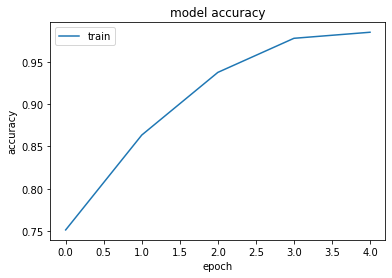

In [15]:
plt.plot(train_history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

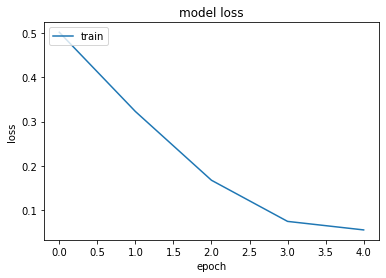

In [16]:
plt.plot(train_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
import math

output_dict = {0:"This sentence is not sexist.", 1:"Sexist"}
new_input = [["I gave you a promotion so you should give me a treat at Dominos in return."], ["I gave you a promotion so you should give me some pleasure in return."], ["This picture has dirty cars in it."], ["Your pictures make me want to do dirty things to you."], ["I have hair on my chest."], ["I want to see your hairy chest."], ["You and I will stay in separate rooms alone at night."], ["I want to stay in a room alone with you at night."],["Can I touch your car?"],["Can I touch you?"]]

new_val0 = bert_encode(new_input[0], tokenizer, max_len=max_len)
new_val1 = bert_encode(new_input[1], tokenizer, max_len=max_len)
new_val2 = bert_encode(new_input[2], tokenizer, max_len=max_len)
new_val3 = bert_encode(new_input[3], tokenizer, max_len=max_len)
new_val4 = bert_encode(new_input[4], tokenizer, max_len=max_len)
new_val5 = bert_encode(new_input[5], tokenizer, max_len=max_len)
new_val6 = bert_encode(new_input[6], tokenizer, max_len=max_len)
new_val7 = bert_encode(new_input[7], tokenizer, max_len=max_len)

print ('The sentence is "' + new_input[0][0] + '"')
print (output_dict[(int(round(model.predict(new_val0)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[1][0] + '"')
print (output_dict[(int(round(model.predict(new_val1)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[2][0] + '"')
print (output_dict[(int(round(model.predict(new_val2)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[3][0] + '"')
print (output_dict[(int(round(model.predict(new_val3)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[4][0] + '"')
print (output_dict[(int(round(model.predict(new_val4)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[5][0] + '"')
print (output_dict[(int(round(model.predict(new_val5)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[6][0] + '"')
print (output_dict[(int(round(model.predict(new_val6)[0][0])))])
print("\n")
print ('The sentence is "' + new_input[7][0] + '"')
print (output_dict[(int(round(model.predict(new_val7)[0][0])))])


The sentence is "I gave you a promotion so you should give me a treat at Dominos in return."
This sentence is not sexist.


The sentence is "I gave you a promotion so you should give me some pleasure in return."
This sentence is not sexist.


The sentence is "This picture has dirty cars in it."
This sentence is not sexist.


The sentence is "Your pictures make me want to do dirty things to you."
Sexist


The sentence is "I have hair on my chest."
This sentence is not sexist.


The sentence is "I want to see your hairy chest."
Sexist


The sentence is "You and I will stay in separate rooms alone at night."
This sentence is not sexist.


The sentence is "I want to stay in a room alone with you at night."
Sexist


In [19]:
y_pred = np.round(y_pred)

In [20]:
from sklearn.metrics import f1_score
print(f1_score(y_val, y_pred, average='macro'))
print(f1_score(y_val, y_pred, average='micro'))
print(f1_score(y_val, y_pred, average='weighted'))
print(f1_score(y_val, y_pred, average=None))
print(f1_score(y_val, y_pred, zero_division=1))

0.8200439927588318
0.8260089686098655
0.826067736844851
[0.7872807  0.85280728]
0.8528072837632776


In [21]:
from sklearn.metrics import recall_score
print(recall_score(y_val, y_pred, average='macro'))
print(recall_score(y_val, y_pred, average='micro'))
print(recall_score(y_val, y_pred, average='weighted'))
print(recall_score(y_val, y_pred, average=None))
print(recall_score(y_val, y_pred, average=None, zero_division=1))

0.8202630702630702
0.8260089686098655
0.8260089686098655
[0.78901099 0.85151515]
[0.78901099 0.85151515]


In [ ]:
from sklearn.metrics import precision_score
print(precision_score(y_val, y_pred, average='macro'))
print(precision_score(y_val, y_pred, average='micro'))
print(precision_score(y_val, y_pred, average='weighted'))
print(precision_score(y_val, y_pred, average=None))
print(precision_score(y_val, y_pred, average=None, zero_division=1))

0.8358441620257985
0.8335644937586685
0.8346587345268909
[0.84899329 0.82269504]
[0.84899329 0.82269504]
